In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import warnings
from corner import corner
from pathlib import Path
import pandas as pd
import logging
import arviz as az

from data import dataloader
from models.model import Model
from models.helpers.results import Results
import matplotlib.pyplot as plt
from scipy import stats as st

# warnings.filterwarnings("ignore", category=RuntimeWarning, module="emcee")
# warnings.filterwarnings("ignore", module="corner")
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz")
# warnings.filterwarnings("ignore", category=RuntimeWarning, module="arviz")
# warnings.filterwarnings("ignore", module="emcee")

RESULTS_PATH = Path("./results")
FIGURES_PATH = Path("./figures")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


$$ \mu(z; \Omega_{m,0}) = m_B - (M_B + \alpha \cdot x + \beta \cdot c + \Delta m_*) + \epsilon $$

More useful for MCMC is to rewrite this in the form of "true = model + error". Note the sign for the error
term doesn't matter.

$$ m_B = [\mu(z; \Omega_{m,0}) + M_B + \alpha \cdot x + \beta \cdot c + \Delta m_*] + \epsilon $$

In [48]:
from models.mass_corrections import sigmoid, sigmoid_sigma

Xmean, Xerr = 10, 1
X = st.norm.rvs(loc=Xmean, scale=Xerr, size=100000)
params = dict(loc=10, size=0.01, slope=100)
sX = sigmoid(X, **params)
true_sd = np.std(sX)
sample_sd = sigmoid_sigma([Xmean], Xerr, **params).mean()

print(true_sd, sample_sd)
print(np.abs(true_sd - sample_sd) / true_sd)

0.004960203151249087 0.00499056571861491
0.006121234643016096


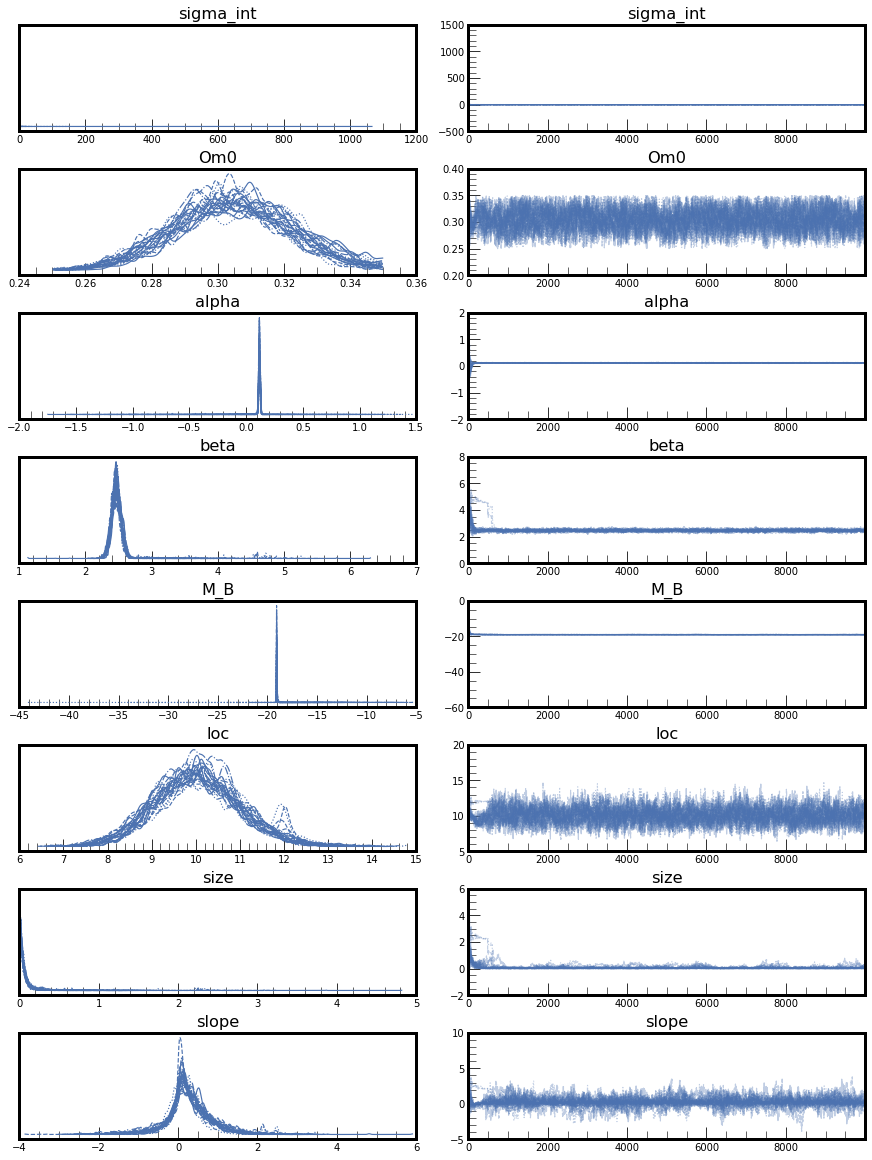

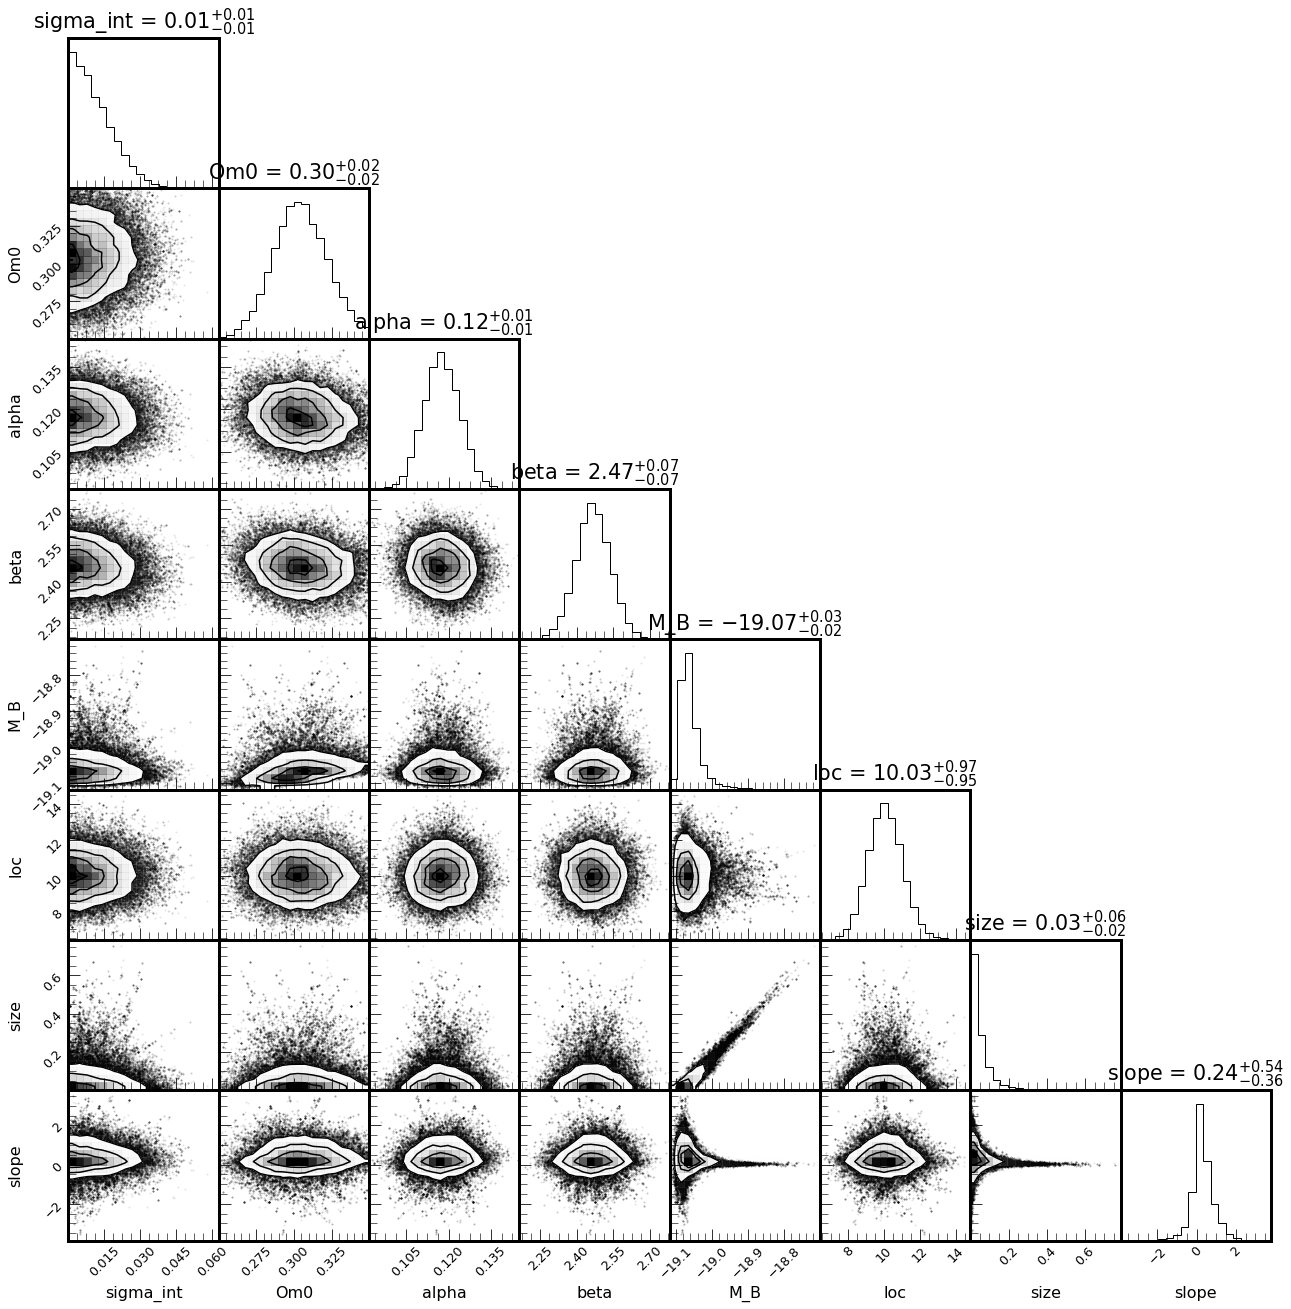

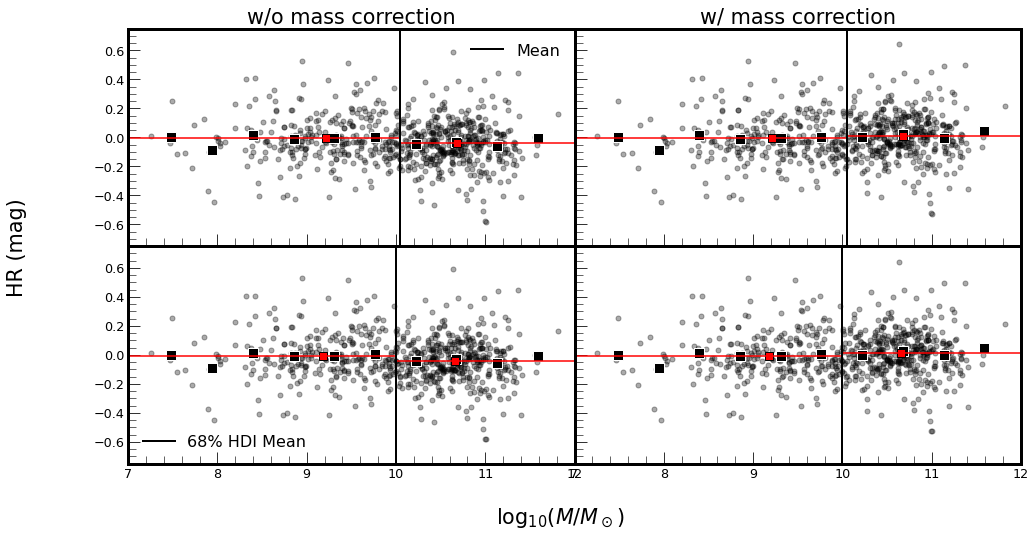

In [3]:
data = dataloader.get_jla()
r = Results("results/jla/sigmoid/results_2021-08-19T2113.hd5", model=Model(H0=70))
r.plot_trace()
r.plot_corner()
r.plot_hr_vs_host_mass(data.query("host_mass > 7"));

# Summary Table

In [4]:
results = [
    {
        "name": "JLA", 
        "mass_step_model": "step", 
        "result_fpath": "results/jla/step/results_2021-08-18T2324.hd5", 
        "comment": "Ignored host mass err"
    },
    {
        "name": "JLA", 
        "mass_step_model": "sigmoid", 
        "result_fpath": "results/jla/sigmoid/results_2021-08-18T2258.hd5", 
        "comment": "Ignored host mass err"
    },
]

def create_row(data_name, data, results_fpath):
    model = Model(H0=70, host_mass_correction_model="step")  # TODO: infer from results file
    
    r = Results(results_fpath, model=model)

    row={}
    row["Data"] = data_name
    row["Mass Correction Model"] = r.model.host_mass_correction_model
    
    savepath = FIGURES_PATH / r.results_fpath.parent.relative_to(RESULTS_PATH)
    savepath.mkdir(exist_ok=True, parents=True)

    r.plot_corner()
    savefile = savepath / f"{r.results_fpath.stem}_corner.pdf"
    plt.savefig(savefile)
    row["Corner Plot"] = f"[pdf](./{savefile})"
    plt.close()

    r.plot_hr_vs_host_mass(data)
    savefile = savepath / f"{r.results_fpath.stem}_hr.pdf"
    plt.savefig(savefile)
    row["HR Plot"] = f"[pdf](./{savefile})"
    plt.close()
    
    return row

def create_table():
    df = pd.DataFrame(columns=["Data", "Mass Correction Model", "Corner Plot", "HR Plot"])

    # JLA
    row = create_row(
        data_name="JLA",
        data=dataloader.get_jla(),
        results_fpath = sorted(list((RESULTS_PATH / "jla").glob("*.hd5")))[-1]
    )
    df = df.append(row, ignore_index=True)

    # ZPEG
    for i in range(1, 16+1):
        glob = list((RESULTS_PATH / f"zpeg/{i}").glob("*.hd5"))
        if not glob:
            continue

        row = create_row(
            data_name=f"ZPEG_{i}",
            data=dataloader.get_zpeg(i),
            results_fpath = sorted(glob)[-1]
        )
        df = df.append(row, ignore_index=True)
        
    # Prospector
    row = create_row(
        data_name="prospector",
        data=dataloader.get_prospector(),
        results_fpath = sorted(list((RESULTS_PATH / "jla").glob("*.hd5")))[-1]
    )
    df = df.append(row, ignore_index=True)
        
    return df
        
with warnings.catch_warnings():
    logging.basicConfig(level=logging.ERROR)
    warnings.simplefilter('ignore')
    df = create_table()
    
from IPython.display import Markdown
md = df.to_markdown()

with open("./model_results.md", "w") as f:
    f.write(md)

display(Markdown(md))

|    | Data       | Mass Correction Model   | Corner Plot                                               | HR Plot                                               |
|---:|:-----------|:------------------------|:----------------------------------------------------------|:------------------------------------------------------|
|  0 | JLA        | step                    | [pdf](figures/jla/results_2021-08-04T0723_corner.pdf)     | [pdf](figures/jla/results_2021-08-04T0723_hr.pdf)     |
|  1 | ZPEG_1     | step                    | [pdf](figures/zpeg/1/results_2021-08-05T0325_corner.pdf)  | [pdf](figures/zpeg/1/results_2021-08-05T0325_hr.pdf)  |
|  2 | ZPEG_2     | step                    | [pdf](figures/zpeg/2/results_2021-08-05T0325_corner.pdf)  | [pdf](figures/zpeg/2/results_2021-08-05T0325_hr.pdf)  |
|  3 | ZPEG_3     | step                    | [pdf](figures/zpeg/3/results_2021-08-05T0325_corner.pdf)  | [pdf](figures/zpeg/3/results_2021-08-05T0325_hr.pdf)  |
|  4 | ZPEG_13    | step                    | [pdf](figures/zpeg/13/results_2021-08-05T0205_corner.pdf) | [pdf](figures/zpeg/13/results_2021-08-05T0205_hr.pdf) |
|  5 | ZPEG_14    | step                    | [pdf](figures/zpeg/14/results_2021-08-05T0205_corner.pdf) | [pdf](figures/zpeg/14/results_2021-08-05T0205_hr.pdf) |
|  6 | ZPEG_15    | step                    | [pdf](figures/zpeg/15/results_2021-08-05T0205_corner.pdf) | [pdf](figures/zpeg/15/results_2021-08-05T0205_hr.pdf) |
|  7 | ZPEG_16    | step                    | [pdf](figures/zpeg/16/results_2021-08-05T0205_corner.pdf) | [pdf](figures/zpeg/16/results_2021-08-05T0205_hr.pdf) |
|  8 | prospector | step                    | [pdf](figures/jla/results_2021-08-04T0723_corner.pdf)     | [pdf](figures/jla/results_2021-08-04T0723_hr.pdf)     |